# Introduction

We will start by holding out a validation data set, and inspect its representativeness. We will lock this data set and use for all models we will train for this project. Afterwards, we will establish our data processing pipeline, including special utility functions we will need. Our goal is to establish the pipeline structure, find the optimal number of features to be included, get a brief idea about the performance of different types of untuned models, finally process both training and validation sets, and finally pickle both processed data sets and the pipeline itself.

# Partition training and validation data sets

In [1]:
# Write/read disk directory
disk = "/Volumes/Iomega_HDD/2016/Data science/Predictive-Modeling-510k-decision-time/"
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
processed510kdata = pd.read_csv(disk+"processed510kdata.csv")

In [2]:
processed510kdata.head()

,KNUMBER,DECISIONTIME,APPLICANT_PRIOR_CLEARANCE_TO_DATE,DEVICENAME_PRIOR_CLEARANCE_TO_DATE,TEXT_FEATURES
0,K170001,150,3,1,acuity 85 oprifocon a rigid gas permeable cont...
1,K170003,227,1,1,zip 4 skin closure device stateca countrycodeu...
2,K170005,352,1,1,flex monoclonal mouse antihuman progesterone r...
3,K170007,148,4,1,acuity 58 enflufocon b rigid gas permeable con...
4,K170008,56,50,1,osteosite bone biopsy needle osteosite bone bi...


In [3]:
processed510kdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24491 entries, 0 to 24490
Data columns (total 5 columns):
KNUMBER                               24491 non-null object
DECISIONTIME                          24491 non-null int64
APPLICANT_PRIOR_CLEARANCE_TO_DATE     24491 non-null int64
DEVICENAME_PRIOR_CLEARANCE_TO_DATE    24491 non-null int64
TEXT_FEATURES                         24491 non-null object
dtypes: int64(3), object(2)
memory usage: 956.8+ KB


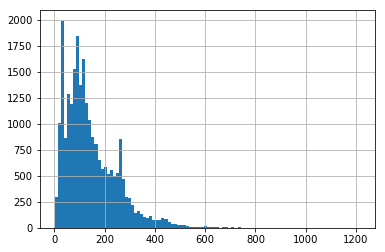

In [4]:
import matplotlib.pyplot as plt
processed510kdata.DECISIONTIME.hist(bins=100)
plt.show()

In [5]:
X = processed510kdata.drop("DECISIONTIME", axis=1)
y = processed510kdata.DECISIONTIME

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
# With currently available data, this is about 16.4K samples. We will increase this set as more data becomes available
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16408 entries, 19500 to 23654
Data columns (total 4 columns):
KNUMBER                               16408 non-null object
APPLICANT_PRIOR_CLEARANCE_TO_DATE     16408 non-null int64
DEVICENAME_PRIOR_CLEARANCE_TO_DATE    16408 non-null int64
TEXT_FEATURES                         16408 non-null object
dtypes: int64(2), object(2)
memory usage: 640.9+ KB


In [7]:
# This is the validation set we will lock down along with the target (y) values. 
# KNUMBER is kept to identifiy and remove these data points from the growing training set in future.
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8083 entries, 20070 to 6014
Data columns (total 4 columns):
KNUMBER                               8083 non-null object
APPLICANT_PRIOR_CLEARANCE_TO_DATE     8083 non-null int64
DEVICENAME_PRIOR_CLEARANCE_TO_DATE    8083 non-null int64
TEXT_FEATURES                         8083 non-null object
dtypes: int64(2), object(2)
memory usage: 315.7+ KB


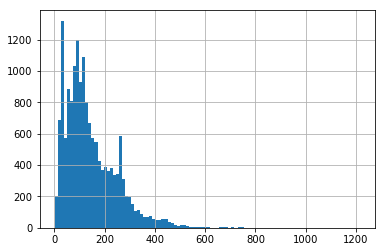

In [8]:
y_train.hist(bins=100)
plt.show()

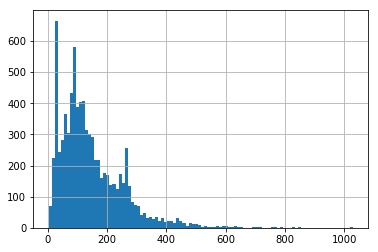

In [9]:
y_val.hist(bins=100)
plt.show()

In [10]:
pd.DataFrame([y_train.describe(),y_val.describe()])

,count,mean,std,min,25%,50%,75%,max
DECISIONTIME,16408.0,143.388774,103.837724,2.0,69.0,117.0,200.0,1213.0
DECISIONTIME,8083.0,144.768155,106.264819,3.0,70.0,118.0,198.0,1029.0


The sampling of the validation set seems to be sufficiently random, targets exhibit similar distributions in both training and validation sets. The outliers seem to be also represented in both cases. 


## Store data sets for modeling

We will store these data sets in the disk.

In [13]:
disk = "/Volumes/Iomega_HDD/2016/Data science/Predictive-Modeling-510k-decision-time/"
# Validation set (Locked down)
with open(disk+"X_val.pkl","wb") as f:
    pickle.dump(X_val,f)

with open(disk+"y_val.pkl","wb") as f:
    pickle.dump(y_val,f)

In [14]:
# Training set (expected to grow in future)
with open(disk+"X_train.pkl","wb") as f:
    pickle.dump(X_train,f)

with open(disk+"y_train.pkl","wb") as f:
    pickle.dump(y_train,f)

# Feature Extraction Pipeline

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MaxAbsScaler,FunctionTransformer, Imputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_extraction.text import HashingVectorizer

# First we build two utility functions to parse numeric and text data, 
# and wrap them using FunctionTransformer, so that they can be integrated into a sklearn pipeline:
def text_columns(X_train):
    return X_train.TEXT_FEATURES

def numeric_columns(X_train):
    numeric = ['APPLICANT_PRIOR_CLEARANCE_TO_DATE','DEVICENAME_PRIOR_CLEARANCE_TO_DATE']
    temp = X_train[numeric]
    return temp

get_numeric_data = FunctionTransformer(func = numeric_columns, validate=False) 
get_text_data = FunctionTransformer(func = text_columns,validate=False) 
# Note how we avoid putting any arguments into text_columns and numeric_columns

# We also need to create our regex token pattern to use in HashingVectorizer. 
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'   
#Note this regex will match either a whitespace or a punctuation to tokenize the string vector on these preferences  

# We also need to redefine the default feature selection function for regression to properly place into our pipeline:
def f_regression(X,Y):
    import sklearn
    return sklearn.feature_selection.f_regression(X,Y,center = False) # default is center = True

# Function to add feature interactions in Sparse matrix
# From: https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py
from itertools import combinations

import numpy as np
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin

class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

# Definition of the actual pipeline
#  We will try to optimize for these values in feature selection
n_tokens = 400
n_features = 400

pipeline510k = Pipeline([
    
    ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer
        
        transformer_list = [
            
            ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline
                
                ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)
            
            ])), # Branching point of the FeatureUnion
            
            ("text_subpipeline",Pipeline([
            
                ("parser",get_text_data), # Step1: parse the text data 
                ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,
                                             stop_words = "english",# We will remove English stop words before tokenization
                                             ngram_range = (1,1), # We will tokenize to single words only
                                             non_negative=True, norm=None, binary=True  
                                            )), # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                            ('dim_red1', SelectKBest(f_regression, k = n_tokens)) # Step3: use dimension reduction to select n_tokens of best features
                
            ]))
        ]
    
    )),# Branching point to the main pipeline: at this point all features are numeric
    
    ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms 
    ("scaler",MaxAbsScaler()), # Scale the features
    ('dim_red2', SelectKBest(f_regression, k =n_features)) # Add another dimension reduction step at the end
])

# Note that we will explore feature selection strategies to determine the number of features to keep after 
# tokenization and feature union

# Feature selection parameter optimization

At this point we will try;

- to understand the least number of features we can select to maximize the predictive performance.
- to develop an intuition for performance of different classes of algorithms in this dataset and establish some benchmarks, before attempting to perform hyperparameter optimization.


In [1]:
# Loading training and validation features and target labels were prepared before:
disk = "/Volumes/Iomega_HDD/2016/Data science/Predictive-Modeling-510k-decision-time/"
import pickle
with open(disk+"X_train.pkl","rb") as f:
    X_train = pickle.load(f)   
with open(disk+"y_train.pkl","rb") as f:
    y_train = pickle.load(f)
        
with open(disk+"X_val.pkl","rb") as f:
    X_val = pickle.load(f)       
with open(disk+"y_val.pkl","rb") as f:
    y_val = pickle.load(f)  

In [49]:
# Write functions to streamline regressors and pipeline tuning
import pickle
from scipy.sparse import vstack
from sklearn.linear_model import Ridge,SGDRegressor, ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime
import warnings
import pandas as pd
warnings.filterwarnings("ignore")


def calculate_rmse(X_val_trans,y_val,reg):
    preds = reg.predict(X_val_trans)
    return np.sqrt(mean_squared_error(y_true=y_val,y_pred=preds))



def streamline_regressors(fpipeline,nfeatures,
                          X_train,y_train,X_val,y_val,
                          disk = "/Volumes/Iomega_HDD/2016/Data science/Predictive-Modeling-510k-decision-time/"):
    """ We will monitor performance of different default regressors."""
    print(">>> streamline_regressors: started exploring model performance using " + str(nfeatures) + " features.")
    ############################################################################
    # Transform the training and test set using the current pipeline
    ############################################################################
    start = datetime.now()
    X_train_trans = fpipeline.fit(X_train,y_train).transform(X_train)
    process = datetime.now() - start
    print(" >>> streamline_regressors: fitted and transformed X_train. It took: " + str(process.seconds/60) + " minutes.")
    print("Shape of X_train is " + str(X_train_trans.shape))
    start = datetime.now()
    X_val_trans = fpipeline.transform(X_val)
    process = datetime.now() - start
    print(" >>> streamline_regressors: transformed X_val. It took: " + str(process.seconds/60) + " minutes.")
    print("Shape of X_val is " + str(X_val_trans.shape))
    #######################################################################
    # Train different regressors report and calculate the validation rmse
    #######################################################################
    # Regressor dictionary
    reg_dict = {
        "Ridge": Ridge(),
        "KernelRidge": KernelRidge(),
        "ElasticNet": ElasticNet(),
        "SGDRegressor":SGDRegressor(),
        "AdaBoostRegressor":AdaBoostRegressor(n_estimators=25),
        "XGBRegressor":XGBRegressor(n_estimators=25)
    }
    
    # Container to collect current rmse scores
    scores = pd.DataFrame()
    scores["nfeatures"] = pd.Series(nfeatures)
    
    for key,value in reg_dict.items():
        start = datetime.now()
        
        reg = value
        reg.fit(X_train_trans.toarray(),y_train)
        val_score =calculate_rmse(X_val_trans.toarray(),y_val,reg)
        scores[key] = pd.Series(val_score)
        
        process = datetime.now() - start
               
        print(" >>> Completed " +str(key) + " regressor with a validation rmse of "+str(val_score) + " it took " +str(process.seconds/60)+ " minutes." )
        print("*" * 80)
    # Return a data frame of validation rmse scores for a given number of features
    return scores

def tune_pipeline(n_features,n_tokens):
    """A function to help us tuning the feature selection steps."""
    n_tokens = n_tokens
    n_features = n_features

    pipeline510k = Pipeline([

        ("union",FeatureUnion( # Note that FeatureUnion() accepts list of tuples, the first half of each tuple is the name of the transformer

            transformer_list = [

                ("numeric_subpipeline", Pipeline([ # Note we have subpipeline branches inside the main pipeline

                    ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                    ("imputer",Imputer()), # Step2: impute missing values (we don't expect any)

                ])), # Branching point of the FeatureUnion

                ("text_subpipeline",Pipeline([

                    ("parser",get_text_data), # Step1: parse the text data 
                    ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC,
                                                 stop_words = "english",# We will remove English stop words before tokenization
                                                 ngram_range = (1,1), # We will tokenize to single words only
                                                 non_negative=True, norm=None, binary=True  
                                                )), # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                ('dim_red1', SelectKBest(f_regression, k = n_tokens)) # Step3: use dimension reduction to select n_tokens of best features

                ]))
            ]

        )),# Branching point to the main pipeline: at this point all features are numeric

        ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms 
        ("scaler",MaxAbsScaler()), # Scale the features
        ('dim_red2', SelectKBest(f_regression, k =n_features)) # Add another dimension reduction step at the end
    ])
    
    return pipeline510k

In [ ]:
# We will first keep the number of tokens constant and search for number of features
# Main loop for feature selection survey

import warnings
import pandas as pd
warnings.filterwarnings("ignore")

nfeatures_list = [10,20,50,100,200,500,1000,2000,5000]
results = pd.DataFrame(columns=["Ridge", "KernelRidge", "ElasticNet", "SGDRegressor","AdaBoostRegressor","XGBRegressor"])

for nfeatures in nfeatures_list:
    # Construct the pipeline
    pipeline510k = tune_pipeline(n_features= nfeatures,n_tokens= 400)
    print("Pipeline constructed using " + str(nfeatures) + " best features.")
    
    results = pd.concat([results, 
                         streamline_regressors(fpipeline=pipeline510k,
                         nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                         X_val = X_val,y_val = y_val)], axis = 0)
    # Save and update the current version of the score table
    with open(disk+"feature_selection_rmse.pkl",wb) as f:
        pickle.dump(results,f)
        
    print("Updated the score table." )
    print("--" * 50)

In [7]:
# Testing how long it takes to transform a small batch of training data
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
start = datetime.now()
X_train_small_p = pipeline510k.fit(X_train.iloc[1:1000,],y_train[1:1000]).transform(X_train.iloc[1:100,])
process = datetime.now() - start
print("It took: " + str(process.seconds/60) + " minutes.")

It took: 2.3 minutes.


In [8]:
# For a training set of 16 k samples, it will take this much hours:
((16000/1000) * 2.3 )/60

0.6133333333333333

## Take home message

The pipeline is way more computationally expensive than we can handle with our current computational capacity even when using chunks. We will not use the feature selection search we hoped to use to find the optimal number of features to include in models. Instead, we will stick with 400 tokens and 400 final features and proceed with two strategies:

For both strategies we need to process our validation set and lock it down before starting the strategies below. 

1. **Train online algorithms using streaming data:** this is an attractive approach since we keep scraping training data and can process it in paralell. This can help us to establish some benchmark performance.

2. **Accumulate training data to train other models:** While processing training data for the strategy 1, we can accumulate processed training data and save them to disk in chunks. Leter these chunks of pipeline-processed training data can be re-loaded, and combined using vstack feature of sparse matrices, to generate a single training set one streaming of the data is completed.

Since additional training data is still being generated, we need to code these strategies to allow smooth processing of streaming data:
    
    - The code needs to filter and skip streaming data associated with validation set data points.
    - The code also need to filter and skip streaming data associated with already processed data points. (We need to cache KNUMBERS associated with data that is already processed by the pipeline)
    
We need to take the advantage of KNUMBERS to skip data points that are already processed.    


# Processing the validation set

In [10]:
# Process the validation set and save into disk
disk = "/Volumes/Iomega_HDD/2016/Data science/Predictive-Modeling-510k-decision-time/"
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
start = datetime.now()
X_val_proc = pipeline510k.fit(X_val,y_val).transform(X_val)
process = datetime.now() - start
print("It took: " + str(process.seconds/60) + " minutes.")
      

It took: 8.483333333333333 minutes.


NameError: name 'wb' is not defined

In [11]:
with open(disk+"X_val.proc.pkl","wb") as f:
        pickle.dump(X_val_proc,f)
print("Saved the processed validation set.")  

Saved the processed validation set.


In [12]:
X_val_proc.shape

(8083, 400)

In [13]:
with open(disk+"processed_chunks/results.pkl", "rb") as f:
        results = pickle.load(f)
results.head() 

,chunk,nsamples,SGDRegressor,PassiveAggressiveRegressor
0,1,100,108.009375,154.202588
0,2,200,123.788000,116.027855
0,3,300,118.453345,120.242843
0,4,400,114.274589,157.438009
0,5,500,110.064550,199.993346


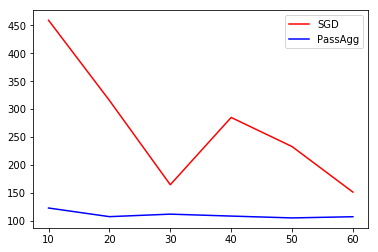

In [93]:
with open(disk+"processed_chunks/results.pkl", "rb") as f:
        results = pickle.load(f)
import matplotlib.pyplot as plt
plt.plot("nsamples","SGD",label = "SGD", data= results, color = "r")
plt.plot("nsamples","PAGG",label = "PassAgg",data= results, color ="b")
#plt.ylim(ymin = 90, ymax = 170)
plt.legend()
plt.show()